In [10]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from xgboost import plot_importance
import yaml
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font', size=24)
plt.rc('axes', titlepad = 20)
plt.rcParams["figure.figsize"] = [16,10]

# Define paths

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data/'
figure_path = os.path.dirname(os.getcwd()) + '/figures'
url_template = 'http://www.rcsb.org/pdb/files/{}.pdb'
rest_url='https://www3.cmbi.umcn.nl/xssp/'

# Define plotting functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def create_scatter(x, y, xlab, ylab, title):
    plt.scatter(x,y)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    max_point = min(max(list(x)),max(list(y)))
    plt.plot([0,max_point],[0,max_point],'--') # identity line
    plt.show()

def create_heatmap(x, y, xlab, ylab, title):
    plt.hist2d(x,y, bins=100)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.ylim(0,10000)
    plt.xlim(0,10000)
    plt.title(title)
    max_point = min(max(list(x)),max(list(y)))
    plt.plot([0,10000],[0,10000],'--') # identity line
    plt.show()

def perc_corr(y_test, pred, x):
    error = abs(y_test-pred)
    y = [sum(error/y_test < i)/len(error) for i in x]
    return(y)

def perc_perc_corr(y_test, pred, x):
    error = abs(y_test-pred)
    y = [sum(error < i)/len(error) for i in x]
    return(y)

def plot_curve(y_test, pred_dict, step, xlab, ylab, title):
    x = [x/step for x in range(step+1)]
    corr_dict = {pred:perc_corr(y_test, pred_dict[pred], x) for pred in pred_dict}

    plt.figure(figsize=(12,8))

    for corr in corr_dict:
        plt.plot([i*100 for i in x],[i*100 for i in corr_dict[corr]], label=corr)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(figure_path + '/' + title + '.png', dpi = 600, bbox_inches='tight')
    plt.show()

def plot_perc_curve(y_test, pred_dict, step, xlab, ylab, title):
    x = [x/step for x in range(step+1)]
    corr_dict = {pred:perc_perc_corr(y_test, pred_dict[pred], x) for pred in pred_dict}

    plt.figure(figsize=(12,8))

    for corr in corr_dict:
        plt.plot([i*100 for i in x],[i*100 for i in corr_dict[corr]], label=corr)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load the test data

In [4]:
df_test_all = pd.read_csv(data_path + '/benchmarking/test_data.csv')
df_test = df_test_all.copy()

# Check if any of the proteins were in the training dataset for PatchProt

In [5]:
train_data = pd.read_csv(data_path + '/patches/Train_LHP.csv')

def convert_string(input_str):
    # Remove the "-" character and capitalize the letters
    converted_str = input_str.replace("-", "").upper()
    return converted_str

train_data['id'] = [convert_string(row) for row in train_data['PDB_ID']]

merged_data = pd.merge(df_test, train_data, on='id', how='inner')
merged_data

,id,tasa,thsa,dssp_sequence,rhsa,tmp,undefined_count,length,perc_undefined_count,entropy,...,rhsa_netsurfp2,on_surface,patch_size,rank,residues,size,PDB_ID,THSA,RHSA,LHP
0,3G0MA,7872,1647,MAALPDKEKLLRNFTRCANWEEKYLYIIELGQRLAELNPQDRNPQN...,0.209223,False,0.0,138.0,0.0,4.141307,...,0.278213,129.0,36.0,1.0,AWAIAMLLICLMFAIALLLIYFALAFMIFAILLVYY,1119.0,3g0m-A,1647.0,0.20922,1119.0
1,1K6KA,8473,1990,MLNQELELSLNMAFARAREHRHEFMTVEHLLLALLSNPSAREALEA...,0.234864,False,0.0,142.0,0.0,3.842851,...,0.235172,125.0,16.0,1.0,LFLLMAFAMLAVLVFV,765.0,1k6k-A,1990.0,0.23486,765.0
2,3NFTA,13480,2727,AMTDDDLRAAGVDRRVPEQKLGAAIDEFASLRLPDRIDGRFVDGRR...,0.202300,False,0.0,262.0,0.0,4.009462,...,0.208330,243.0,16.0,1.0,IILLLIILLVLLVVAF,572.0,3nft-A,2727.0,0.20230,0.0
3,1A5TA,15998,4143,MRWYPWLRPDFEKLVASYQAGRGHHALLIQALPGMGDDALIYALSR...,0.258970,False,0.0,323.0,0.0,4.008869,...,0.272171,282.0,19.0,1.0,WYYYAMAVLWMFYAAALYL,696.0,1a5t-A,4143.0,0.25897,696.0
4,5FAFA,7471,1602,GSHHVVPNEVVVQRLFQVKGRRVVRATEVPVSWESFKNGDCFILDL...,0.214429,False,0.0,113.0,0.0,4.062462,...,0.209706,106.0,13.0,1.0,LAVCVVVAYFAVI,574.0,5faf-A,1602.0,0.21443,565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2WAOA,13219,3561,GILYNGRFDFSDPNGPKCAWSGSNVELNFYGTEASVTIKSGGENWF...,0.269385,False,0.0,325.0,0.0,4.166493,...,0.241054,272.0,18.0,1.0,FLFLAAALFIVFWYLFYL,828.0,2wao-A,3561.0,0.26938,828.0
703,2VDFA,12939,5524,ANEFTVHTDLSSISSTRAFLKEKHKAAKHIGVRADIPFDANQGIRL...,0.426926,False,0.0,225.0,0.0,4.017141,...,0.416031,222.0,54.0,1.0,IVAVIIVFYLILYWFIAVAVWIIFIFYALAVLLYFAILAALFLLFL...,3861.0,2vdf-A,5524.0,0.42693,3861.0
704,2IIHA,8302,2367,RPRMVDVTEKPETFRTATAEAFVELTEEALSALEKGGVGKGDPLVV...,0.285112,False,0.0,146.0,0.0,3.781968,...,0.289850,127.0,44.0,1.0,ALALALVLLAALAAVICVVLLAIVWYVVVMMVLLLMMVVLLLAI,1926.0,2iih-A,2367.0,0.28511,1926.0
705,3JU4A,36407,10757,VPRGSAKGDGVTDDTAALTSALNDTPVGQKINGNGKTYKVTSLPDI...,0.295465,False,0.0,670.0,0.0,4.163715,...,0.270134,584.0,46.0,1.0,VVAYLVVIYVLYMFFLVYIVLLAMAFAIVAAIAIICFIFLFALFYF,4488.0,3ju4-A,10757.0,0.29547,943.0


In [6]:
# overlapping = list(train_data['id'])
# df_test = df_test[~df_test['id'].isin(overlapping)]

R2 score  NetSurfP2 0.9150507663407101
R2 score  GFM 0.7540891715058301
R2 score  Combination Model 0.9123645802082502
R2 score  TFM 0.7092106322452914
R2 score  Naive Model 0.7159218320167122


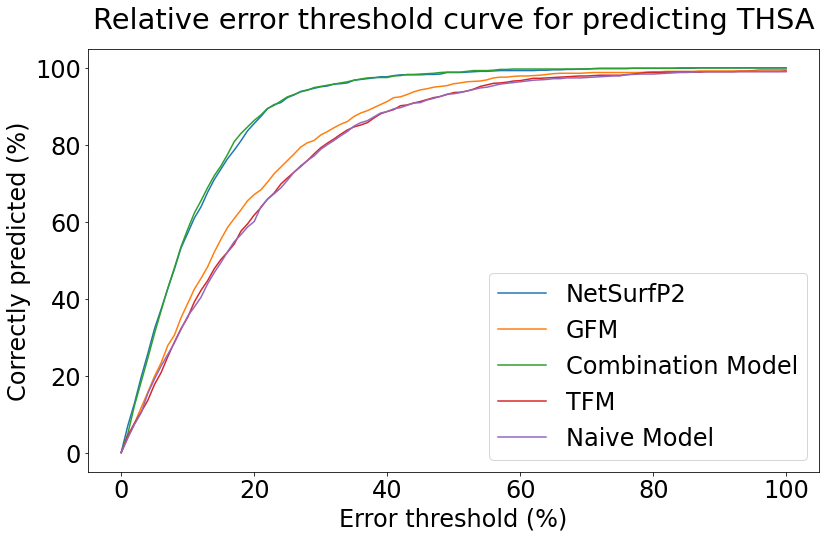

In [7]:
names =  {'gfm':'GFM', 'nsp2_gfm':'Combination Model', 'tfm':'TFM', 'length':'Naive Model'}
pred_dict = {'NetSurfP2':df_test['thsa_netsurfp2']}
for name in names:
    if name == 'tfm':
        result = pd.read_csv(data_path + 'benchmarking/thsa_tfm_prediction.csv')['x']
    else:
        result = pd.read_csv(data_path + 'benchmarking/thsa_'+name+'_prediction.csv')['prediction']
    
    pred_dict[names[name]] = result
    
for name in pred_dict:
    print('R2 score ',name, r2_score(df_test['thsa'], pred_dict[name]))

xlab = 'Error threshold (%)'
ylab = 'Correctly predicted (%)'
title = 'Relative error threshold curve for predicting THSA'
plot_curve(df_test['thsa'], pred_dict, 100, xlab, ylab, title)

R2 score  NetSurfP2 0.7684990757381781
R2 score  GFM 0.40188392023956254
R2 score  Combination Model 0.7825153868421194
R2 score  TFM 0.1339664174346763
R2 score  Naive Model 0.04671900514929617


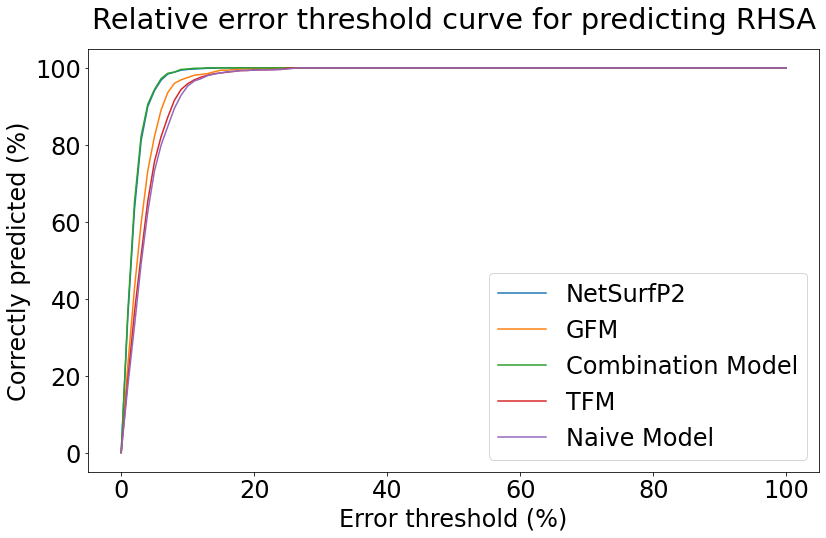

In [8]:
names =  {'gfm':'GFM', 'nsp2_gfm':'Combination Model', 'tfm':'TFM', 'length':'Naive Model'}
pred_dict = {'NetSurfP2':df_test['rhsa_netsurfp2']}
for name in names.keys():
    if name == 'tfm':
        result = pd.read_csv(data_path + 'benchmarking/rhsa_tfm_prediction.csv')['x']
    else:
        result = pd.read_csv(data_path + 'benchmarking/rhsa_'+name+'_prediction.csv')['prediction']
    
    pred_dict[names[name]] = result

for name in pred_dict:
    print('R2 score ',name, r2_score(df_test['rhsa'], pred_dict[name]))
    
xlab = 'Error threshold (%)'
ylab = 'Correctly predicted (%)'
title = 'Relative error threshold curve for predicting RHSA'
plot_perc_curve(df_test['rhsa'], pred_dict, 100, xlab, ylab, title)

R2 score  NetSurfP2 trained model 0.430891519315191
R2 score  GFM 0.12184275218819451
R2 score  Combination Model 0.4493733536193497
R2 score  TFM -0.003208559248944809
R2 score  Naive Model 0.007725849514613858


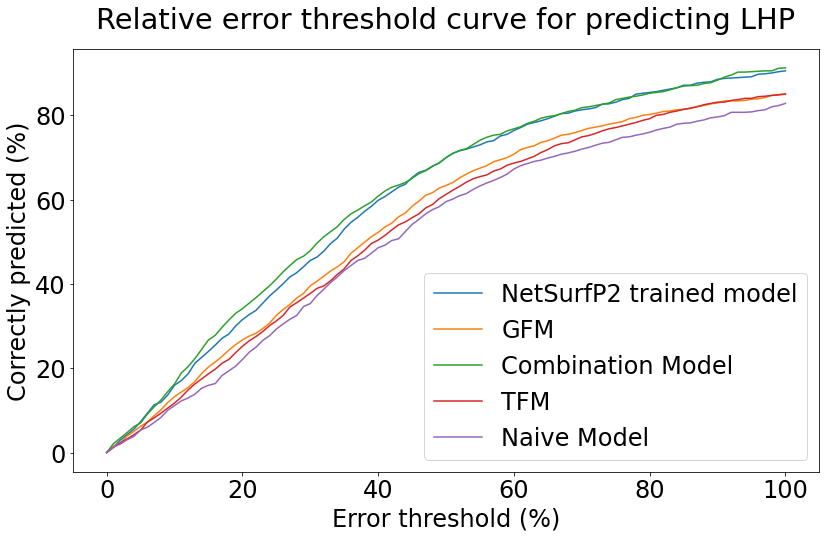

In [9]:
names =  {'nsp2':'NetSurfP2 trained model', 'gfm':'GFM', 'nsp2_gfm':'Combination Model', 'tfm':'TFM', 'length':'Naive Model'}
pred_dict = {}
for name in names:
    if name == 'tfm':
        result = pd.read_csv(data_path + 'benchmarking/lhp_tfm_prediction.csv')['x']
    else:
        result = pd.read_csv(data_path + 'benchmarking/lhp_'+name+'_prediction.csv')['prediction']

    pred_dict[names[name]] = result

for name in pred_dict:
    print('R2 score ',name, r2_score(df_test['size'], pred_dict[name]))
    
xlab = 'Error threshold (%)'
ylab = 'Correctly predicted (%)'
title = 'Relative error threshold curve for predicting LHP'
plot_curve(df_test['size'], pred_dict, 100, xlab, ylab, title)